## Set up the notebook

In [1]:
# Import modules

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
import torchvision
from torchvision.transforms import functional as TF
from skimage import transform
import torch.optim as optim

# Import tqdm for progress bar
from tqdm import tqdm

# Numpy
import numpy as np

# PyArrow for parquet reading
import pyarrow as pa
import pyarrow.parquet as pq

# Pandas
import pandas as pd

# Matplotlib
from matplotlib import pyplot as plt

# Pickle
import pickle

# Debugging tool
from IPython.core.debugger import set_trace

# Copy
from copy import deepcopy

# CV2 for immages
import cv2

In [2]:
# Training Model Params
epochs = 60
batch_size = 32
learning_rate = 0.001


# Image params
img_height = 137
img_width = 236
img_resize = 136
validation_split= 0.2

# Data Loading params
label_file = '/storage/train.csv'
char_type_gr = 'grapheme_root'
char_type_vd = 'vowel_diacritic'
char_type_cd = 'consonant_diacritic'




In [3]:
# Set up GPU

# Check if GPU is available and set up the device
if torch.cuda.is_available():
    device = torch.device('cuda:0')

print(device)

cuda:0


## Load the data

In [4]:
# # Load once, then pickle

# # #initialize train image with train image 0
# train_image_0 = pq.read_table('/storage/training/train_image_data_0.parquet').to_pandas().set_index('image_id')
# train_image_torch = torch.from_numpy(train_image_0.values).to(device) 
# del train_image_0

# # train image 1
# train_image_1 = pq.read_table('/storage/training/train_image_data_1.parquet').to_pandas().set_index('image_id')
# train_image_1 = torch.from_numpy(train_image_1.values).to(device)
# train_image_torch = torch.cat((train_image_torch, train_image_1), 0)
# del train_image_1

# train_image_2 = pq.read_table('/storage/training/train_image_data_2.parquet').to_pandas().set_index('image_id')
# train_image_2 = torch.from_numpy(train_image_2.values).to(device)
# train_image_torch = torch.cat((train_image_torch, train_image_2), 0)
# del train_image_2

# train_image_3 = pq.read_table('/storage/training/train_image_data_3.parquet').to_pandas().set_index('image_id')
# train_image_3 = torch.from_numpy(train_image_3.values).to(device)
# train_image_torch = torch.cat((train_image_torch, train_image_3), 0) # serialize into a pickle
# del train_image_3

# print(train_image_torch.shape)

# # upload to drive using pickle
# with open('train_image_torch.pickle', 'wb') as f:
#     pickle.dump(train_image_torch, f, protocol=4)

In [5]:
# Load the training image data from the pickled file, ensuring to load to the GPU
with open('train_image_torch.pickle', 'rb') as f:
    
    train_image_torch = pickle.load(f).to(device)
    
print(train_image_torch.shape)

torch.Size([200840, 32332])


In [6]:
# Deifine a class for loading data

class Dataset(data.Dataset):
    '''Charactizes a dataset for use with pytorch'''
    def __init__(self, X, label_file, char_type, transform=None, img_height=137, img_width=236, img_resize=None, rgb=False):
        '''Initialization
        X: torch tensor that includes all of the imported data
        label_file: location of label csv
        char_type: string name of label column from label csv
        transform: pytorch transform
        img_height: height of image for reshaping the tensor
        img_width: width of image for reshaping the tensor
        img_resize: crop the image square (img_resize x img_resize)
        '''
        # Assign variables
        self.X = X
        self.transform = transform
        self.img_height = img_height
        self.img_width = img_width
        self.img_resize = img_resize
        self.rgb = rgb
        
        # read CSV for the character type into a GPU torch tensor
        self.labels = torch.tensor(pd.read_csv(label_file)[char_type]).to(device)
        
    def __len__(self):
        '''total number of samples'''
        return len(self.labels)
    
    def __getitem__(self, idx):
        '''generates one sample of data'''     
        
        # retrieve, reshape, and normalize the values of the tensor to be between 0 and 1   
        img = self.X[idx].reshape(1, self.img_height, self.img_width)/255.
        
        # Crop images into squares for cnn
        if self.img_resize:
            # Define box for resize
            lower = int(self.img_height/2 - self.img_resize/2)
            upper = int(self.img_height/2 + self.img_resize/2)
            left = int(self.img_width/2 - self.img_resize/2)
            right = int(self.img_width/2 + self.img_resize/2)
            
            # crop the image
            img = img[:, lower:upper, left:right]
        
        # Reformat for use with resnet
        if self.rgb:
            img = torch.stack((img,)*3)
            img = torch.squeeze(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#             img = torch.unsqueeze(img, 0)
        
        # retrieve the proper label for this image
        label = self.labels[idx]
        
        # package image and label into a sample
        sample = {'image': img, 'label': label}
        
        # perform any transforms if prescribed
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        
        return sample



In [7]:
def validation_splitter(src_dataset, validation_split):
    '''Creates index to split'''
    
    train_index = int((1 - validation_split) * len(src_dataset))
    test_index = len(src_dataset) - train_index
    
    return [train_index, test_index]

In [8]:
def create_loader(source_tensor, label_file, char_type, img_resize, validation_split, batch_size, rgb=False):
    
    # Create dataset
    dataset = Dataset(source_tensor,
                     label_file,
                     char_type,
                     img_resize=img_resize,
                     rgb=rgb)
    
    torch.manual_seed(42)
    
    # Split Data
    val_split_indexes = validation_splitter(dataset, validation_split)
    train, test = data.random_split(dataset, val_split_indexes)
    print(f'{char_type} train size: {val_split_indexes[0]}    test size: {val_split_indexes[1]}')
    
    # Create loaders
    train_loader = data.DataLoader(train, 
                                  batch_size=batch_size)
    test_loader = data.DataLoader(test,
                                 batch_size=batch_size)
    
    return train_loader, test_loader




In [9]:
grapheme_root_trainer, grapheme_root_tester = create_loader(train_image_torch, 
                                                            label_file, 
                                                            char_type_gr,
                                                            img_resize,
                                                            validation_split,
                                                            batch_size)

vowel_diacritic_trainer, vowel_diacritic_tester = create_loader(train_image_torch,
                                                               label_file,
                                                               char_type_vd,
                                                               img_resize,
                                                               validation_split,
                                                               batch_size)

consonant_diacritic_trainer, consonant_diacritic_tester = create_loader(train_image_torch,
                                                                       label_file,
                                                                       char_type_cd,
                                                                       img_resize,
                                                                       validation_split,
                                                                       batch_size)

grapheme_root train size: 160672    test size: 40168
vowel_diacritic train size: 160672    test size: 40168
consonant_diacritic train size: 160672    test size: 40168


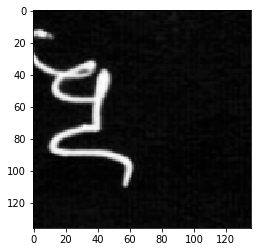

In [10]:
# Plot a random image to see if data was correctly loaded

# # Create grapheme root dataset
grapheme_root_data = Dataset(train_image_torch,
                             label_file, 
                             char_type_gr,
                             img_resize=img_resize)

# Choose a random number
random_image = np.random.randint(0, train_image_torch.shape[0])

# move the sample for plotting to the cpu to be accessible to numpy
sample_0 = grapheme_root_data[random_image]['image'].to(torch.device('cpu'))
sample_0 = sample_0.numpy().reshape(img_resize,img_resize)

# Plot the image
plt.imshow(sample_0, cmap="Greys")
plt.imsave('sample_image.png', sample_0, cmap='Greys')
with open('sample_0.pickle', 'wb') as f:
    pickle.dump(sample_0, f, protocol=4)
with open('label_0.pickle', 'wb') as f:
    pickle.dump(grapheme_root_data[random_image]['label'], f, protocol=4)
with open('label_0_vowel.pickle', 'wb') as f:
    pickle.dump(torch.tensor(pd.read_csv(label_file)[char_type_vd].iloc[random_image]).to(device), f, protocol=4)
with open('label_0_consonant.pickle', 'wb') as f:
    pickle.dump(torch.tensor(pd.read_csv(label_file)[char_type_cd].iloc[random_image]).to(device), f, protocol=4)


In [11]:
print(random_image)

53595


## Define the network

In [12]:
# Define a function that calculates a convnet's output channels
def output_size(in_size, kernel_size, stride, padding=0):

    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

    return(output)

In [13]:
# Define a structure for the neural network

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
       
        # Define the Parameters for the neural network
        # see if neutron can help visualize my network
        # Look at fast ai tutorials for CNN
        
        # Convolution layer 1
        self.conv1_input_channels = 1
        self.conv1_kernel_size = 9
        self.conv1_stride = 1
        self.conv1_output_channels = 16
        self.conv1_output_dim = output_size(img_resize, 
                                            self.conv1_kernel_size, 
                                            self.conv1_stride)
        
        # Pooling layer 1
        self.pool1_kernel_size = 11
        self.pool1_stride = 2
        self.pool1_output_dim = output_size(self.conv1_output_dim, 
                                            self.pool1_kernel_size, 
                                            self.pool1_stride)
       
        #conv 2
        self.conv2_input_channels = self.conv1_output_channels
        self.conv2_kernel_size = 8
        self.conv2_stride = 1
        self.conv2_output_channels = 32
        self.conv2_output_dim = output_size(self.pool1_output_dim,
                                            self.conv2_kernel_size, 
                                            self.conv2_stride)
        
        # Pooling layer 2
        self.pool2_kernel_size = 8
        self.pool2_stride = 2
        self.pool2_output_dim = output_size(self.conv2_output_dim,
                                           self.pool2_kernel_size,
                                           self.pool2_stride)
        
        # Fully connected 1 (input is batch_size x height x width after pooling)
        self.fc1_input_features = self.conv2_output_channels * self.pool2_output_dim**2
        self.fc1_output_features = 256
       
        # Fully connected 2
        self.fc2_input_features = self.fc1_output_features
        self.fc2_output_features = 200
           
        # Fully Connected 3 (output is number of features)
        self.fc3_input_features = self.fc2_output_features
        self.fc3_output_features = 168
        
        # Create the layers
        self.conv1 = nn.Conv2d(self.conv1_input_channels, 
                               self.conv1_output_channels, 
                               self.conv1_kernel_size, 
                               stride=self.conv1_stride)
        
        self.max_pool1 = nn.MaxPool2d(self.pool1_kernel_size, self.pool1_stride)
        
        self.conv2 = nn.Conv2d(self.conv2_input_channels, 
                               self.conv2_output_channels, 
                               self.conv2_kernel_size,
                               stride=self.conv2_stride)
        
        self.max_pool2 = nn.MaxPool2d(self.pool2_kernel_size, self.pool2_stride)
        
        self.flatten = Flatten()
        
        self.fc1 = nn.Linear(self.fc1_input_features, self.fc1_output_features)
        
        self.fc2 = nn.Linear(self.fc2_input_features, self.fc2_output_features)
        
        self.fc3 = nn.Linear(self.fc3_input_features, self.fc3_output_features)
        
        self.features = [self.conv1, self.conv2, self.fc1, self.fc2, self.fc3]

      

    def forward(self, x):
        # run the tensor through the layers
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        # number of flat features to determine the size of the first fully connected layer
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

    
# move this net to the GPU
grapheme_root_net = Net().to(device)
vowel_diacritic_net = deepcopy(Net()).to(device)
consonant_diacritic_net = deepcopy(Net()).to(device)

# copy the net to an ONNX file for visualization

_ = torch.onnx.export(grapheme_root_net,  grapheme_root_data[random_image]['image'].unsqueeze(1), "banglanet.onnx", verbose=True)

# specify loss criteria and optimizers
criterion = nn.CrossEntropyLoss().to(device)

grapheme_root_optimizer = optim.SGD(grapheme_root_net.parameters(), lr=learning_rate, momentum=0.9)
vowel_diacritic_optimizer = optim.SGD(vowel_diacritic_net.parameters(), lr=learning_rate, momentum=0.9)
consonant_diacritic_optimizer = optim.SGD(consonant_diacritic_net.parameters(), lr= learning_rate, momentum=0.9)


# Print a summary of the network
print(grapheme_root_net)

graph(%input.1 : Float(1, 1, 136, 136),
      %conv1.weight : Float(16, 1, 9, 9),
      %conv1.bias : Float(16),
      %conv2.weight : Float(32, 16, 8, 8),
      %conv2.bias : Float(32),
      %fc1.weight : Float(256, 16928),
      %fc1.bias : Float(256),
      %fc2.weight : Float(200, 256),
      %fc2.bias : Float(200),
      %fc3.weight : Float(168, 200),
      %fc3.bias : Float(168)):
  %11 : Float(1, 16, 128, 128) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[9, 9], pads=[0, 0, 0, 0], strides=[1, 1]](%input.1, %conv1.weight, %conv1.bias) # /usr/local/lib/python3.6/dist-packages/torch/nn/modules/conv.py:342:0
  %12 : Float(1, 16, 128, 128) = onnx::Relu(%11) # /usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:914:0
  %13 : Float(1, 16, 59, 59) = onnx::MaxPool[kernel_shape=[11, 11], pads=[0, 0, 0, 0], strides=[2, 2]](%12) # /usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:488:0
  %14 : Float(1, 32, 52, 52) = onnx::Conv[dilations=[1, 1], group=1, kernel

## Train and Run the Models

In [14]:
def test_model(model, dataloader):
        
    correct = 0
    total = 0
    with torch.no_grad():
        for item in dataloader:
            images, labels = item['image'], item['label']
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total


In [15]:
def run_model(model, dataloader, epochs, optimizer, criterion, test_dataloader):    
    epoch_loss = np.empty_like(range(epochs))
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, item in enumerate(dataloader, 0):
            inputs, labels = item['image'], item['label']

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        val_error = test_model(model, test_dataloader)
            
        print(f'epoch: {epoch + 1}, loss: {running_loss/i}, validation accuracy: {val_error}')
        epoch_loss[epoch] = running_loss/i

    return model, epoch_loss

In [16]:
def plot_loss(loss, char_type=''):
    
    epoch_labels = range(1, len(loss)+1)
    
    plt.plot(epoch_labels, loss)
    plt.title(f'Loss over epochs {char_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [17]:
# grapheme_model, grapheme_loss = run_model(grapheme_root_net, 
#                                           grapheme_root_trainer, 
#                                           epochs, 
#                                           grapheme_root_optimizer, 
#                                           criterion,
#                                           grapheme_root_tester)

# plot_loss(grapheme_loss, char_type_gr)
# torch.save(grapheme_model, 'storage/models/grapheme_root.pth')

# with open('grapheme_root_loss.pickle', 'wb') as f:
#     pickle.dump(grapheme_loss, f, protocol=4)

In [18]:
# vowel_diacritic_model, vowel_loss = run_model(vowel_diacritic_net,
#                                  vowel_diacritic_trainer,
#                                  epochs,
#                                  vowel_diacritic_optimizer,
#                                  criterion,
#                                  vowel_diacritic_tester)

# plot_loss(vowel_loss, char_type_vd)
# torch.save(vowel_diacritic_model, 'storage/models/vowel_diacritic.pth')

# with open('vowel_diacritic_loss.pickle', 'wb') as f:
#     pickle.dump(vowel_loss, f, protocol=4)

In [19]:
# consonant_diacritic_model, consonant_loss= run_model(consonant_diacritic_net,
#                                       consonant_diacritic_trainer,
#                                       epochs,
#                                       consonant_diacritic_optimizer,
#                                       criterion,
#                                       consonant_diacritic_tester)
# plot_loss(consonant_loss, char_type_cd)
# torch.save(consonant_diacritic_model, 'storage/models/consonant_diacritic.pth')

# with open('consonant_diacritic_loss.pickle', 'wb') as f:
#     pickle.dump(consonant_loss, f, protocol=4)

0.6982921728739295


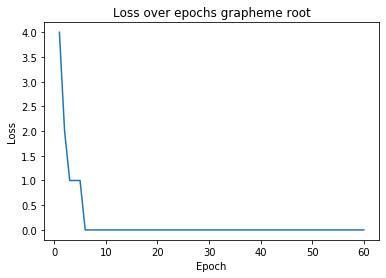

In [20]:
grapheme_model_loaded = torch.load('storage/models/grapheme_root.pth')
with open('grapheme_root_loss.pickle', 'rb') as f:
    grapheme_loss_loaded = pickle.load(f)
print(test_model(grapheme_model_loaded, grapheme_root_tester))
plot_loss(grapheme_loss_loaded, "grapheme root")

0.8746265684126668


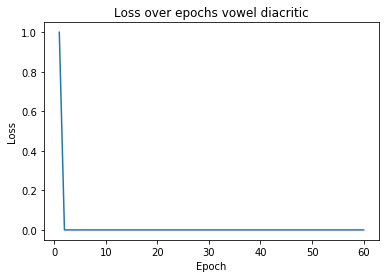

In [21]:
vowel_model_loaded = torch.load('storage/models/vowel_diacritic.pth')
with open('vowel_diacritic_loss.pickle', 'rb') as f:
    vowel_loss_loaded = pickle.load(f)
print(test_model(vowel_model_loaded, vowel_diacritic_tester))
plot_loss(vowel_loss_loaded, "vowel diacritic")

0.9134883489344752


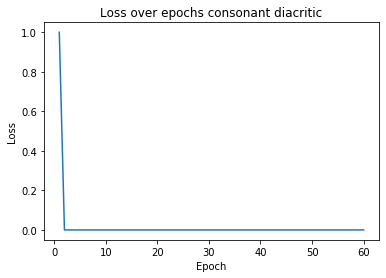

In [22]:
consonant_model_loaded = torch.load('storage/models/consonant_diacritic.pth')
with open('consonant_diacritic_loss.pickle', 'rb') as f:
    consonant_loss_loaded = pickle.load(f)
print(test_model(consonant_model_loaded, consonant_diacritic_tester))
plot_loss(consonant_loss_loaded, "consonant diacritic")

## Build a Resnet

In [23]:
# Resnet requires 3 channel input, so load Data as RGB

grapheme_root_trainer_resnet, grapheme_root_tester_resnet = create_loader(train_image_torch, 
                                                                          label_file, 
                                                                          char_type_gr,
                                                                          img_resize,
                                                                          validation_split,
                                                                          batch_size,
                                                                          rgb=True)

vowel_diacritic_trainer_resnet, vowel_diacritic_tester_resnet = create_loader(train_image_torch,
                                                                              label_file,
                                                                              char_type_vd,
                                                                              img_resize,
                                                                             validation_split,
                                                                             batch_size,
                                                                             rgb=True)

consonant_diacritic_trainer_resnet, consonant_diacritic_tester_resnet = create_loader(train_image_torch,
                                                                                     label_file,
                                                                                     char_type_cd,
                                                                                     img_resize,
                                                                                     validation_split,
                                                                                     batch_size,
                                                                                     rgb=True)

grapheme_root train size: 160672    test size: 40168
vowel_diacritic train size: 160672    test size: 40168
consonant_diacritic train size: 160672    test size: 40168


In [25]:
# Load Resnet Models
grapheme_model_resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet18', pretrained=True).to(device)
vowel_model_resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet18', pretrained=True).to(device)
consonant_model_resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet18', pretrained=True).to(device)


# Set up optimizers
grapheme_root_optimizer_resnet = optim.SGD(grapheme_model_resnet.parameters(), lr=learning_rate, momentum=0.9)
vowel_diacritic_optimizer_resnet = optim.SGD(vowel_model_resnet.parameters(), lr=learning_rate, momentum=0.9)
consonant_diacritic_optimizer_resnet = optim.SGD(consonant_model_resnet.parameters(), lr= learning_rate, momentum=0.9)

# Use onnx to visualize the model

grapheme_root_resnet_data = Dataset(train_image_torch,
                                    label_file, 
                                    char_type_gr,
                                    img_resize=img_resize,
                                    rgb=True)
import pdb; pdb.set_trace()
_ = torch.onnx.export(grapheme_model_resnet,  grapheme_root_resnet_data[random_image]['image'].unsqueeze(0), "banglanet_resnet.onnx", verbose=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


--Return--
> <ipython-input-25-2ac6899576e9>(19)<module>()->None
-> import pdb; pdb.set_trace()


(Pdb)  c


graph(%input.1 : Float(1, 3, 136, 136),
      %conv1.weight : Float(64, 3, 7, 7),
      %bn1.weight : Float(64),
      %bn1.bias : Float(64),
      %bn1.running_mean : Float(64),
      %bn1.running_var : Float(64),
      %bn1.num_batches_tracked : Long(),
      %layer1.0.conv1.weight : Float(64, 64, 3, 3),
      %layer1.0.bn1.weight : Float(64),
      %layer1.0.bn1.bias : Float(64),
      %layer1.0.bn1.running_mean : Float(64),
      %layer1.0.bn1.running_var : Float(64),
      %layer1.0.bn1.num_batches_tracked : Long(),
      %layer1.0.conv2.weight : Float(64, 64, 3, 3),
      %layer1.0.bn2.weight : Float(64),
      %layer1.0.bn2.bias : Float(64),
      %layer1.0.bn2.running_mean : Float(64),
      %layer1.0.bn2.running_var : Float(64),
      %layer1.0.bn2.num_batches_tracked : Long(),
      %layer1.1.conv1.weight : Float(64, 64, 3, 3),
      %layer1.1.bn1.weight : Float(64),
      %layer1.1.bn1.bias : Float(64),
      %layer1.1.bn1.running_mean : Float(64),
      %layer1.1.bn1.runnin

 10%|█         | 1/10 [03:38<32:42, 218.05s/it]

epoch: 1, loss: 1.1060860577332545, validation accuracy: 0.8620045807608047


 20%|██        | 2/10 [07:16<29:05, 218.17s/it]

epoch: 2, loss: 0.32359800897983915, validation accuracy: 0.8885431189006174


 30%|███       | 3/10 [10:55<25:28, 218.36s/it]

epoch: 3, loss: 0.1724406153646361, validation accuracy: 0.8966092411870146


 40%|████      | 4/10 [14:35<21:52, 218.76s/it]

epoch: 4, loss: 0.08454238715399784, validation accuracy: 0.9017625970922127


 50%|█████     | 5/10 [18:14<18:15, 219.05s/it]

epoch: 5, loss: 0.03663890247207239, validation accuracy: 0.9089822744473213


 60%|██████    | 6/10 [21:54<14:37, 219.39s/it]

epoch: 6, loss: 0.015496973696339178, validation accuracy: 0.9118203545110536


 70%|███████   | 7/10 [25:34<10:58, 219.46s/it]

epoch: 7, loss: 0.007053204990953088, validation accuracy: 0.9153804023102967


 80%|████████  | 8/10 [29:13<07:18, 219.26s/it]

epoch: 8, loss: 0.0039867934240288, validation accuracy: 0.916575383389763


 90%|█████████ | 9/10 [32:51<03:38, 218.93s/it]

epoch: 9, loss: 0.0027766603872595554, validation accuracy: 0.9171728739294961


100%|██████████| 10/10 [36:30<00:00, 219.04s/it]

epoch: 10, loss: 0.002191248108666257, validation accuracy: 0.9173720374427405


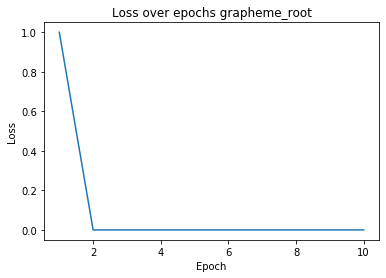

In [31]:
# Train A resnet model
grapheme_model_resnet, grapheme_loss_resnet = run_model(grapheme_model_resnet, 
                                                        grapheme_root_trainer_resnet, 
                                                        10, 
                                                        grapheme_root_optimizer_resnet, 
                                                        criterion,
                                                        grapheme_root_tester_resnet)

plot_loss(grapheme_loss_resnet, char_type_gr)
torch.save(grapheme_model_resnet, 'storage/models/grapheme_root_resnet.pth')

with open('grapheme_root_loss_resnet.pickle', 'wb') as f:
    pickle.dump(grapheme_loss_resnet, f, protocol=4)

In [35]:
vowel_loss_resnet

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

 10%|█         | 1/10 [03:36<32:25, 216.17s/it]

epoch: 1, loss: 0.3045459295708345, validation accuracy: 0.9434624576777534


 20%|██        | 2/10 [07:12<28:49, 216.23s/it]

epoch: 2, loss: 0.12449611343473077, validation accuracy: 0.9516779525990838


 30%|███       | 3/10 [10:48<25:13, 216.22s/it]

epoch: 3, loss: 0.06928833328276517, validation accuracy: 0.9511551483768174


 40%|████      | 4/10 [14:25<21:38, 216.34s/it]

epoch: 4, loss: 0.03476023035517252, validation accuracy: 0.951727743477395


 50%|█████     | 5/10 [18:01<18:01, 216.29s/it]

epoch: 5, loss: 0.02008862774448091, validation accuracy: 0.9518273252340171


 60%|██████    | 6/10 [21:37<14:25, 216.26s/it]

epoch: 6, loss: 0.0165948766458082, validation accuracy: 0.9529974108743279


 70%|███████   | 7/10 [25:13<10:48, 216.05s/it]

epoch: 7, loss: 0.014243854024258268, validation accuracy: 0.951503684524995


 80%|████████  | 8/10 [28:50<07:12, 216.28s/it]

epoch: 8, loss: 0.011258047747896962, validation accuracy: 0.9544911372236606


 90%|█████████ | 9/10 [32:27<03:36, 216.62s/it]

epoch: 9, loss: 0.007791793334531594, validation accuracy: 0.9551384186417048


100%|██████████| 10/10 [36:03<00:00, 216.37s/it]

epoch: 10, loss: 0.005830197974267709, validation accuracy: 0.955785700059749


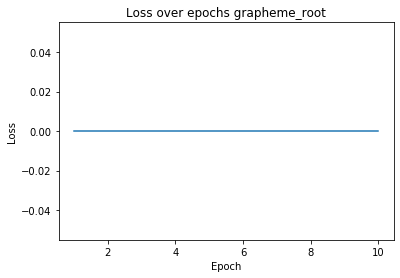

In [26]:
vowel_model_resnet, vowel_loss_resnet = run_model(vowel_model_resnet, 
                                                        vowel_diacritic_trainer_resnet, 
                                                        10, 
                                                        vowel_diacritic_optimizer_resnet, 
                                                        criterion,
                                                        vowel_diacritic_tester_resnet)

plot_loss(vowel_loss_resnet, char_type_gr)
torch.save(vowel_model_resnet, 'storage/models/vowel_diacritic_resnet.pth')

with open('vowel_diacritic_loss_resnet.pickle', 'wb') as f:
    pickle.dump(vowel_loss_resnet, f, protocol=4)

 10%|█         | 1/10 [03:36<32:30, 216.72s/it]

epoch: 1, loss: 0.2322453204586924, validation accuracy: 0.9563085042820155


 20%|██        | 2/10 [07:13<28:54, 216.80s/it]

epoch: 2, loss: 0.09704800953131273, validation accuracy: 0.9610137422824139


 30%|███       | 3/10 [10:51<25:20, 217.20s/it]

epoch: 3, loss: 0.04993906808030083, validation accuracy: 0.9615863373829915


 40%|████      | 4/10 [14:29<21:44, 217.43s/it]

epoch: 4, loss: 0.02377726182163474, validation accuracy: 0.9612875921131249


 50%|█████     | 5/10 [18:07<18:07, 217.54s/it]

epoch: 5, loss: 0.016965409763068318, validation accuracy: 0.9631547500497909


 70%|███████   | 7/10 [25:23<10:52, 217.65s/it]

epoch: 7, loss: 0.011260880802969534, validation accuracy: 0.9644493128858793


 80%|████████  | 8/10 [28:59<07:14, 217.17s/it]

epoch: 8, loss: 0.009328855971891092, validation accuracy: 0.9651463851822346


 90%|█████████ | 9/10 [32:35<03:36, 216.92s/it]

epoch: 9, loss: 0.005790380557694758, validation accuracy: 0.965071698864768


100%|██████████| 10/10 [36:11<00:00, 217.16s/it]

epoch: 10, loss: 0.004057168099747236, validation accuracy: 0.9678101971718781


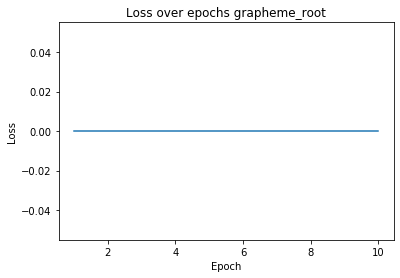

In [27]:
consonant_model_resnet, consonant_loss_resnet = run_model(consonant_model_resnet, 
                                                        consonant_diacritic_trainer_resnet, 
                                                        10, 
                                                        consonant_diacritic_optimizer_resnet, 
                                                        criterion,
                                                        consonant_diacritic_tester_resnet)

plot_loss(consonant_loss_resnet, char_type_gr)
torch.save(consonant_model_resnet, 'storage/models/consonant_diacritic_resnet.pth')

with open('consonant_diacritic_loss_resnet.pickle', 'wb') as f:
    pickle.dump(consonant_loss_resnet, f, protocol=4)